In [3]:
# Imports PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Imports utilitaires
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from tqdm import tqdm

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Vérification GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")
print(f"🎮 GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}")

🖥️  Device: cuda
🎮 GPU: NVIDIA GeForce GTX 1060


In [5]:
# Chemins
DATA_DIR = Path("/mnt/d/VENV/Recycle moi/dataset")
TRAIN_DIR = DATA_DIR / "train"
VALID_DIR = DATA_DIR / "valid"
TEST_DIR = DATA_DIR / "test"

# Hyperparamètres
BATCH_SIZE = 32        # Nombre d'images par batch
NUM_EPOCHS = 10        # Nombre d'epochs d'entraînement
LEARNING_RATE = 0.001  # Taux d'apprentissage
IMG_SIZE = 224         # Taille des images (224x224)

# Classes
CLASSES = ['cardboard', 'e-waste', 'glass', 'medical', 'metal', 'paper', 'plastic']
NUM_CLASSES = len(CLASSES)

print(f"📊 Configuration:")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Epochs: {NUM_EPOCHS}")
print(f"   - Learning rate: {LEARNING_RATE}")
print(f"   - Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   - Classes: {NUM_CLASSES}")
print(f"   - Device: {device}")

📊 Configuration:
   - Batch size: 32
   - Epochs: 10
   - Learning rate: 0.001
   - Image size: 224x224
   - Classes: 7
   - Device: cuda


In [6]:
# Transformations pour TRAIN (avec augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),           # Redimensionner
    transforms.RandomHorizontalFlip(p=0.5),            # Flip horizontal aléatoire
    transforms.RandomRotation(degrees=15),             # Rotation ±15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Variations lumière
    transforms.ToTensor(),                             # Convertir en tensor
    transforms.Normalize(                              # Normaliser avec stats ImageNet
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Transformations pour VALID et TEST (sans augmentation)
eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("✅ Transformations définies")
print(f"   - Train: Resize + Augmentation + Normalize")
print(f"   - Valid/Test: Resize + Normalize uniquement")

✅ Transformations définies
   - Train: Resize + Augmentation + Normalize
   - Valid/Test: Resize + Normalize uniquement


In [7]:
# Charger les datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
valid_dataset = datasets.ImageFolder(VALID_DIR, transform=eval_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=eval_transforms)

# Créer les DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      # Mélanger à chaque epoch
    num_workers=4,     # Paralléliser le chargement
    pin_memory=True    # Optimisation GPU
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,     # Pas besoin de mélanger pour validation
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"✅ DataLoaders créés")
print(f"   - Train batches: {len(train_loader)} ({len(train_dataset)} images)")
print(f"   - Valid batches: {len(valid_loader)} ({len(valid_dataset)} images)")
print(f"   - Test batches: {len(test_loader)} ({len(test_dataset)} images)")

✅ DataLoaders créés
   - Train batches: 447 (14279 images)
   - Valid batches: 56 (1781 images)
   - Test batches: 57 (1793 images)


In [12]:
class WasteClassifierCNN(nn.Module):
    """
    CNN simple pour classification de déchets.
    Architecture: 3 blocs Conv + 2 couches Dense
    """
    def __init__(self, num_classes=7):
        super(WasteClassifierCNN, self).__init__()
        
        # BLOC 1: Convolution 32 filtres
        self.conv1 = nn.Conv2d(
            in_channels=3,      # RGB (3 canaux)
            out_channels=32,    # 32 filtres
            kernel_size=3,      # Filtre 3x3
            padding=1           # Garde la taille
        )
        self.bn1 = nn.BatchNorm2d(32)  # Normalisation par batch
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Réduit de moitié
        
        # BLOC 2: Convolution 64 filtres
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # BLOC 3: Convolution 128 filtres
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Calcul de la taille après convolutions
        # 224 -> 112 -> 56 -> 28
        # Donc: 28 * 28 * 128 = 100,352
        
        # COUCHES DENSES (Fully Connected)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28 * 128, 256)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout 50%
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        """
        Passage avant (forward pass).
        
        Args:
            x: Tensor d'images (batch_size, 3, 224, 224)
        
        Returns:
            Tensor de prédictions (batch_size, num_classes)
        """
        # Bloc 1
        x = self.conv1(x)      # (batch, 3, 224, 224) -> (batch, 32, 224, 224)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)      # (batch, 32, 224, 224) -> (batch, 32, 112, 112)
        
        # Bloc 2
        x = self.conv2(x)      # (batch, 32, 112, 112) -> (batch, 64, 112, 112)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)      # (batch, 64, 112, 112) -> (batch, 64, 56, 56)
        
        # Bloc 3
        x = self.conv3(x)      # (batch, 64, 56, 56) -> (batch, 128, 56, 56)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)      # (batch, 128, 56, 56) -> (batch, 128, 28, 28)
        
        # Flatten + Dense
        x = self.flatten(x)    # (batch, 128, 28, 28) -> (batch, 100352)
        x = self.fc1(x)        # (batch, 100352) -> (batch, 256)
        x = self.relu4(x)
        x = self.dropout(x)    # Dropout pendant l'entraînement
        x = self.fc2(x)        # (batch, 256) -> (batch, 7)
        
        return x

# Créer le modèle
model = WasteClassifierCNN(num_classes=NUM_CLASSES)
model = model.to(device)  # Envoyer sur GPU

# Afficher l'architecture
print("🏗️  ARCHITECTURE DU MODÈLE")
print("=" * 60)
print(model)
print("=" * 60)

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Paramètres totaux: {total_params:,}")
print(f"📊 Paramètres entraînables: {trainable_params:,}")

🏗️  ARCHITECTURE DU MODÈLE
WasteClassifierCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (relu4): ReLU()
  (dropout): 

In [14]:
# Fonction de perte (Loss)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE
)

# Learning rate scheduler (optionnel mais recommandé)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # Réduit LR quand la loss diminue plus
    factor=0.5,        # Multiplie LR par 0.5
    patience=3,        # Attend 3 epochs sans amélioration
    verbose=True       # Affiche quand le LR change
)

print("✅ Loss: CrossEntropyLoss")
print("✅ Optimizer: Adam")
print(f"✅ Learning Rate: {LEARNING_RATE}")
print("✅ Scheduler: ReduceLROnPlateau")

✅ Loss: CrossEntropyLoss
✅ Optimizer: Adam
✅ Learning Rate: 0.001
✅ Scheduler: ReduceLROnPlateau


In [15]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Entraîne le modèle sur une epoch.
    
    Returns:
        tuple: (loss moyenne, accuracy)
    """
    model.train()  # Mode entraînement (active dropout)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Barre de progression
    pbar = tqdm(loader, desc='Training', leave=False)
    
    for images, labels in pbar:
        # Envoyer sur GPU
        images = images.to(device)
        labels = labels.to(device)
        
        # Réinitialiser les gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Mise à jour des poids
        optimizer.step()
        
        # Statistiques
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Mettre à jour la barre de progression
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

In [16]:
def validate(model, loader, criterion, device):
    """
    Évalue le modèle sur le validation set.
    
    Returns:
        tuple: (loss moyenne, accuracy)
    """
    model.eval()  # Mode évaluation (désactive dropout)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Pas besoin de calculer les gradients
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass uniquement
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistiques
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("✅ Fonctions train et validate définies")

✅ Fonctions train et validate définies


In [9]:
# Historique pour les graphiques
history = {
    'train_loss': [],
    'train_acc': [],
    'valid_loss': [],
    'valid_acc': []
}

# Meilleure accuracy (pour sauvegarder le meilleur modèle)
best_valid_acc = 0.0

print("🚀 DÉBUT DE L'ENTRAÎNEMENT")
print("=" * 60)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\n📅 Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # ENTRAÎNEMENT
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # VALIDATION
    valid_loss, valid_acc = validate(
        model, valid_loader, criterion, device
    )
    
    # Sauvegarder l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)
    
    # Afficher les résultats
    print(f"\n📊 Résultats Epoch {epoch+1}:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%")
    
    # Sauvegarder le meilleur modèle
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_baseline_model.pth')
        print(f"   ✅ Nouveau meilleur modèle sauvegardé! (Acc: {best_valid_acc:.2f}%)")
    
    # Ajuster le learning rate
    scheduler.step(valid_loss)
    
    print("-" * 60)

# Temps total
total_time = time.time() - start_time
print(f"\n⏱️  Temps total d'entraînement: {total_time/60:.2f} minutes")
print(f"🏆 Meilleure validation accuracy: {best_valid_acc:.2f}%")
print("=" * 60)

🚀 DÉBUT DE L'ENTRAÎNEMENT

📅 Epoch 1/10
------------------------------------------------------------


Training:  22%|██▏       | 100/447 [00:57<03:16,  1.76it/s, loss=1.9249, acc=15.22%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  25%|██▍       | 110/447 [01:02<02:52,  1.96it/s, loss=1.9614, acc=15.34%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  30%|███       | 135/447 [01:19<03:21,  1.55it/s, loss=1.9402, acc=15.37%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  83%|████████▎ | 369/447 [05:15<00:50,  1.54it/s, loss=1.9532, acc=15.51%]/home/bavithy/miniconda3/envs/recyclemoi/lib/p


📊 Résultats Epoch 1:
   Train Loss: 2.5514 | Train Acc: 15.85%
   Valid Loss: 1.9402 | Valid Acc: 16.79%
   ✅ Nouveau meilleur modèle sauvegardé! (Acc: 16.79%)
------------------------------------------------------------

📅 Epoch 2/10
------------------------------------------------------------


Training:   0%|          | 0/447 [00:00<?, ?it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   1%|          | 5/447 [00:13<16:56,  2.30s/it, loss=1.9441, acc=15.62%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  36%|███▌      | 162/447 [03:57<04:52,  1.03s/it, loss=1.9163, acc=16.80%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  49%|████▉     | 218/447 [05:20<03:09,  1.21it/s, loss=1.9435, acc=16.83%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:


📊 Résultats Epoch 2:
   Train Loss: 1.9396 | Train Acc: 16.84%
   Valid Loss: 1.9391 | Valid Acc: 16.79%
------------------------------------------------------------

📅 Epoch 3/10
------------------------------------------------------------


Training:   4%|▍         | 18/447 [00:19<10:10,  1.42s/it, loss=1.9494, acc=15.28%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   5%|▍         | 22/447 [00:22<05:44,  1.23it/s, loss=1.9132, acc=16.62%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   6%|▌         | 26/447 [00:28<06:52,  1.02it/s, loss=1.9324, acc=16.59%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  31%|███       | 137/447 [02:31<03:02,  1.69it/s, loss=1.9693, acc=16.54%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pyth


📊 Résultats Epoch 3:
   Train Loss: 1.9397 | Train Acc: 16.91%
   Valid Loss: 1.9386 | Valid Acc: 16.96%
   ✅ Nouveau meilleur modèle sauvegardé! (Acc: 16.96%)
------------------------------------------------------------

📅 Epoch 4/10
------------------------------------------------------------


Training:   2%|▏         | 10/447 [00:13<08:40,  1.19s/it, loss=1.9623, acc=16.88%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   8%|▊         | 36/447 [00:35<04:54,  1.39it/s, loss=1.9400, acc=17.45%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  19%|█▉        | 85/447 [01:21<04:02,  1.49it/s, loss=1.9435, acc=17.61%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  22%|██▏       | 98/447 [01:33<03:47,  1.53it/s, loss=1.9505, acc=17.19%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pytho


📊 Résultats Epoch 4:
   Train Loss: 1.9391 | Train Acc: 16.84%
   Valid Loss: 1.9389 | Valid Acc: 16.84%
------------------------------------------------------------

📅 Epoch 5/10
------------------------------------------------------------


Training:   9%|▉         | 40/447 [00:48<07:29,  1.11s/it, loss=1.9411, acc=15.70%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  12%|█▏        | 54/447 [00:59<05:47,  1.13it/s, loss=1.9381, acc=15.97%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  18%|█▊        | 81/447 [01:28<04:39,  1.31it/s, loss=1.9200, acc=16.90%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  27%|██▋       | 121/447 [02:05<04:05,  1.33it/s, loss=1.8872, acc=17.72%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pyth


📊 Résultats Epoch 5:
   Train Loss: 1.9391 | Train Acc: 16.84%
   Valid Loss: 1.9389 | Valid Acc: 16.84%
------------------------------------------------------------

📅 Epoch 6/10
------------------------------------------------------------


Training:   4%|▍         | 20/447 [00:23<04:34,  1.56it/s, loss=1.9408, acc=16.88%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   6%|▌         | 27/447 [00:28<04:22,  1.60it/s, loss=1.9378, acc=16.78%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  28%|██▊       | 123/447 [02:10<04:36,  1.17it/s, loss=1.9166, acc=17.17%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  37%|███▋      | 167/447 [03:01<03:31,  1.32it/s, loss=1.9771, acc=16.97%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pyt


📊 Résultats Epoch 6:
   Train Loss: 1.9391 | Train Acc: 16.84%
   Valid Loss: 1.9389 | Valid Acc: 16.84%
------------------------------------------------------------

📅 Epoch 7/10
------------------------------------------------------------


Training:   6%|▌         | 26/447 [00:26<05:07,  1.37it/s, loss=1.9571, acc=15.14%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   9%|▊         | 38/447 [00:36<03:45,  1.81it/s, loss=1.9487, acc=16.12%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  12%|█▏        | 54/447 [00:52<04:39,  1.40it/s, loss=1.9329, acc=16.90%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  27%|██▋       | 119/447 [01:44<03:12,  1.70it/s, loss=1.9761, acc=16.81%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pyth


📊 Résultats Epoch 7:
   Train Loss: 1.9392 | Train Acc: 16.84%
   Valid Loss: 1.9389 | Valid Acc: 16.84%
------------------------------------------------------------

📅 Epoch 8/10
------------------------------------------------------------


Training:   2%|▏         | 8/447 [00:05<04:18,  1.70it/s, loss=1.9694, acc=14.06%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   5%|▍         | 22/447 [00:14<03:41,  1.92it/s, loss=1.9469, acc=16.19%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   8%|▊         | 37/447 [00:24<03:48,  1.80it/s, loss=1.9342, acc=16.05%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  13%|█▎        | 56/447 [00:34<03:29,  1.87it/s, loss=1.9325, acc=16.41%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python


📊 Résultats Epoch 8:
   Train Loss: 1.9390 | Train Acc: 16.84%
   Valid Loss: 1.9389 | Valid Acc: 16.84%
------------------------------------------------------------

📅 Epoch 9/10
------------------------------------------------------------


Training:   9%|▉         | 40/447 [00:22<03:28,  1.95it/s, loss=1.9482, acc=17.03%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  17%|█▋        | 76/447 [00:41<03:11,  1.93it/s, loss=1.9132, acc=16.12%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  39%|███▉      | 174/447 [01:58<02:40,  1.70it/s, loss=1.9276, acc=17.04%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  40%|███▉      | 178/447 [02:01<02:46,  1.61it/s, loss=1.9226, acc=17.08%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pyt


📊 Résultats Epoch 9:
   Train Loss: 1.9390 | Train Acc: 16.84%
   Valid Loss: 1.9389 | Valid Acc: 16.84%
------------------------------------------------------------

📅 Epoch 10/10
------------------------------------------------------------


Training:   3%|▎         | 15/447 [00:12<04:34,  1.57it/s, loss=1.9530, acc=17.50%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   8%|▊         | 36/447 [00:26<03:59,  1.72it/s, loss=1.9152, acc=17.45%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  12%|█▏        | 52/447 [00:37<03:44,  1.76it/s, loss=1.9510, acc=18.57%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  39%|███▉      | 174/447 [02:26<03:00,  1.51it/s, loss=1.9239, acc=16.86%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pyth


📊 Résultats Epoch 10:
   Train Loss: 1.9390 | Train Acc: 16.84%
   Valid Loss: 1.9389 | Valid Acc: 16.84%
------------------------------------------------------------

⏱️  Temps total d'entraînement: 80.32 minutes
🏆 Meilleure validation accuracy: 16.96%


# Debug pour savoir le problème

In [19]:
# Charger le meilleur modèle
model.load_state_dict(torch.load('best_baseline_model.pth'))
model.eval()

# Prendre un batch du validation set
dataiter = iter(valid_loader)
images, labels = next(dataiter)

# Prédire
with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Afficher les résultats
print("🔍 INSPECTION DES PRÉDICTIONS")
print("=" * 60)
print(f"Vraies classes (premiers 10): {labels[:10].tolist()}")
print(f"Prédictions    (premiers 10): {predicted[:10].cpu().tolist()}")
print()

# Compter les prédictions par classe
from collections import Counter
pred_counts = Counter(predicted.cpu().tolist())
label_counts = Counter(labels.tolist())

print("📊 Distribution des prédictions sur ce batch:")
for i, class_name in enumerate(CLASSES):
    print(f"   {class_name:12s}: Prédit {pred_counts[i]:2d} fois | Réel {label_counts[i]:2d} fois")
print("=" * 60)

/tmp/ipykernel_124691/2557723594.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_baseline_model.pth'))
/home/bavithy/miniconda3/en

🔍 INSPECTION DES PRÉDICTIONS
Vraies classes (premiers 10): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Prédictions    (premiers 10): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

📊 Distribution des prédictions sur ce batch:
   cardboard   : Prédit  0 fois | Réel 32 fois
   e-waste     : Prédit 32 fois | Réel  0 fois
   glass       : Prédit  0 fois | Réel  0 fois
   medical     : Prédit  0 fois | Réel  0 fois
   metal       : Prédit  0 fois | Réel  0 fois
   paper       : Prédit  0 fois | Réel  0 fois
   plastic     : Prédit  0 fois | Réel  0 fois


In [20]:
# Réentraîner sur UN SEUL batch pour voir si ça apprend
model.train()
dataiter = iter(train_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

# Forward
optimizer.zero_grad()
outputs = model(images)
loss = criterion(outputs, labels)

# Backward
loss.backward()

# Inspecter les gradients
print("🔍 INSPECTION DES GRADIENTS")
print("=" * 60)
for name, param in model.named_parameters():
    if param.grad is not None:
        grad_mean = param.grad.abs().mean().item()
        print(f"{name:30s}: grad mean = {grad_mean:.6f}")
    else:
        print(f"{name:30s}: ⚠️ PAS DE GRADIENT!")
print("=" * 60)

🔍 INSPECTION DES GRADIENTS
conv1.weight                  : grad mean = 0.000000
conv1.bias                    : grad mean = 0.000000
bn1.weight                    : grad mean = 0.000000
bn1.bias                      : grad mean = 0.000000
conv2.weight                  : grad mean = 0.000000
conv2.bias                    : grad mean = 0.000000
bn2.weight                    : grad mean = 0.000000
bn2.bias                      : grad mean = 0.000000
conv3.weight                  : grad mean = 0.000000
conv3.bias                    : grad mean = 0.000000
bn3.weight                    : grad mean = 0.000000
bn3.bias                      : grad mean = 0.000000
fc1.weight                    : grad mean = 0.000000
fc1.bias                      : grad mean = 0.000000
fc2.weight                    : grad mean = 0.000000
fc2.bias                      : grad mean = 0.028086


In [21]:
# Créer un tout petit dataset (10 images)
small_dataset = torch.utils.data.Subset(train_dataset, range(10))
small_loader = DataLoader(small_dataset, batch_size=10, shuffle=False)

# Nouveau modèle frais
test_model = WasteClassifierCNN(num_classes=NUM_CLASSES).to(device)
test_optimizer = optim.Adam(test_model.parameters(), lr=0.01)  # LR plus élevé
test_criterion = nn.CrossEntropyLoss()

print("🧪 TEST D'OVERFITTING SUR 10 IMAGES")
print("=" * 60)
print("Si le modèle fonctionne, il DOIT atteindre 100% accuracy sur ces 10 images\n")

test_model.train()
for epoch in range(50):  # 50 epochs sur 10 images
    for images, labels in small_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        test_optimizer.zero_grad()
        outputs = test_model(images)
        loss = test_criterion(outputs, labels)
        loss.backward()
        test_optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == labels).sum().item() / labels.size(0) * 100
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:2d}/50 - Loss: {loss.item():.4f} - Acc: {acc:.2f}%")

print("=" * 60)
print("✅ Si accuracy = 100% → Le modèle PEUT apprendre, le problème est ailleurs")
print("❌ Si accuracy reste basse → Bug dans le modèle ou le code")
print("=" * 60)

🧪 TEST D'OVERFITTING SUR 10 IMAGES
Si le modèle fonctionne, il DOIT atteindre 100% accuracy sur ces 10 images

Epoch 10/50 - Loss: 0.0000 - Acc: 100.00%
Epoch 20/50 - Loss: 0.0000 - Acc: 100.00%
Epoch 30/50 - Loss: 0.0000 - Acc: 100.00%
Epoch 40/50 - Loss: 0.0000 - Acc: 100.00%
Epoch 50/50 - Loss: 0.0000 - Acc: 100.00%
✅ Si accuracy = 100% → Le modèle PEUT apprendre, le problème est ailleurs
❌ Si accuracy reste basse → Bug dans le modèle ou le code


In [22]:
print("📊 CALCUL DES STATISTIQUES DU DATASET")
print("=" * 60)

# Fonction pour calculer mean et std
def calculate_dataset_stats(loader):
    """Calcule mean et std de toutes les images"""
    mean = torch.zeros(3)  # RGB
    std = torch.zeros(3)
    total_images = 0
    
    for images, _ in tqdm(loader, desc="Calcul stats"):
        batch_samples = images.size(0)  # Nombre d'images dans le batch
        images = images.view(batch_samples, images.size(1), -1)  # (B, C, H*W)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples
    
    mean /= total_images
    std /= total_images
    
    return mean, std

# Créer un loader SANS normalisation (juste Resize + ToTensor)
temp_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
temp_dataset = datasets.ImageFolder(TRAIN_DIR, transform=temp_transforms)
temp_loader = DataLoader(temp_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Calculer
mean, std = calculate_dataset_stats(temp_loader)

print(f"\n✅ Statistiques de notre dataset:")
print(f"   Mean: {mean.tolist()}")
print(f"   Std:  {std.tolist()}")
print(f"\n📌 Stats ImageNet (pour comparaison):")
print(f"   Mean: [0.485, 0.456, 0.406]")
print(f"   Std:  [0.229, 0.224, 0.225]")
print("=" * 60)

📊 CALCUL DES STATISTIQUES DU DATASET


Calcul stats:   0%|          | 0/447 [00:00<?, ?it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Calcul stats:   8%|▊         | 36/447 [00:09<01:44,  3.92it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Calcul stats:  15%|█▌        | 69/447 [00:19<01:54,  3.30it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Calcul stats:  16%|█▋        | 73/447 [00:20<01:59,  3.14it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expresse


✅ Statistiques de notre dataset:
   Mean: [0.6488807201385498, 0.6303250789642334, 0.6019631624221802]
   Std:  [0.2114768922328949, 0.2123720496892929, 0.22156652808189392]

📌 Stats ImageNet (pour comparaison):
   Mean: [0.485, 0.456, 0.406]
   Std:  [0.229, 0.224, 0.225]


# Modèle v2 - Correction

### 1. Utiliser Kaiming Initialization (pour éviter vanishing gradients)
### 2. Calculer les vraies stats de normalisation de notre dataset
### 3. Utiliser LeakyReLU au lieu de ReLU (ne "meurt" jamais)

In [26]:
class WasteClassifierCNN_v2(nn.Module):
    """
    CNN amélioré avec :
    - Kaiming initialization
    - LeakyReLU (ne meurt pas)
    - Architecture plus simple
    """
    def __init__(self, num_classes=7):
        super(WasteClassifierCNN_v2, self).__init__()
        
        # BLOC 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.LeakyReLU(0.1)  # LeakyReLU au lieu de ReLU
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # BLOC 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU(0.1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # BLOC 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU(0.1)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Dense layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28 * 128, 256)
        self.relu4 = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
        # INITIALISATION KAIMING (crucial!)
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialisation Kaiming pour éviter vanishing gradients"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

print("✅ Nouveau modèle WasteClassifierCNN_v2 défini")
print("   - LeakyReLU (ne meurt pas)")
print("   - Kaiming initialization")

✅ Nouveau modèle WasteClassifierCNN_v2 défini
   - LeakyReLU (ne meurt pas)
   - Kaiming initialization


In [27]:
# NOS VRAIES STATS
DATASET_MEAN = [0.649, 0.630, 0.602]
DATASET_STD = [0.211, 0.212, 0.222]

# Nouvelles transformations avec les bonnes stats
train_transforms_v2 = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATASET_MEAN, std=DATASET_STD)  # NOS STATS !
])

eval_transforms_v2 = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATASET_MEAN, std=DATASET_STD)  # NOS STATS !
])

# Re-créer les datasets
train_dataset_v2 = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms_v2)
valid_dataset_v2 = datasets.ImageFolder(VALID_DIR, transform=eval_transforms_v2)
test_dataset_v2 = datasets.ImageFolder(TEST_DIR, transform=eval_transforms_v2)

# Re-créer les DataLoaders
train_loader_v2 = DataLoader(
    train_dataset_v2,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

valid_loader_v2 = DataLoader(
    valid_dataset_v2,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader_v2 = DataLoader(
    test_dataset_v2,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("✅ Nouveaux DataLoaders créés avec NOS stats")
print(f"   Mean: {DATASET_MEAN}")
print(f"   Std:  {DATASET_STD}")

✅ Nouveaux DataLoaders créés avec NOS stats
   Mean: [0.649, 0.63, 0.602]
   Std:  [0.211, 0.212, 0.222]


In [28]:
# Créer le nouveau modèle
model_v2 = WasteClassifierCNN_v2(num_classes=NUM_CLASSES)
model_v2 = model_v2.to(device)

# Nouveaux optimizer et criterion
criterion_v2 = nn.CrossEntropyLoss()
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.0001)  # LR réduit !
scheduler_v2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_v2,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

print("✅ Modèle v2 créé et envoyé sur GPU")
print(f"✅ Learning rate : 0.0001 (10x plus petit)")
print(f"✅ Optimizer : Adam")

# Compter les paramètres
total_params = sum(p.numel() for p in model_v2.parameters())
print(f"📊 Paramètres : {total_params:,}")

✅ Modèle v2 créé et envoyé sur GPU
✅ Learning rate : 0.0001 (10x plus petit)
✅ Optimizer : Adam
📊 Paramètres : 25,785,863


In [17]:
# Historique v2
history_v2 = {
    'train_loss': [],
    'train_acc': [],
    'valid_loss': [],
    'valid_acc': []
}

best_valid_acc_v2 = 0.0

print("🚀 ENTRAÎNEMENT v2 (AVEC CORRECTIONS)")
print("=" * 60)
print("Corrections appliquées :")
print("  ✅ Normalisation avec NOS stats (pas ImageNet)")
print("  ✅ LeakyReLU (ne meurt pas)")
print("  ✅ Kaiming initialization")
print("  ✅ Learning rate réduit (0.0001)")
print("=" * 60)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\n📅 Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # ENTRAÎNEMENT
    train_loss, train_acc = train_one_epoch(
        model_v2, train_loader_v2, criterion_v2, optimizer_v2, device
    )
    
    # VALIDATION
    valid_loss, valid_acc = validate(
        model_v2, valid_loader_v2, criterion_v2, device
    )
    
    # Sauvegarder l'historique
    history_v2['train_loss'].append(train_loss)
    history_v2['train_acc'].append(train_acc)
    history_v2['valid_loss'].append(valid_loss)
    history_v2['valid_acc'].append(valid_acc)
    
    # Afficher les résultats
    print(f"\n📊 Résultats Epoch {epoch+1}:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%")
    
    # Sauvegarder le meilleur modèle
    if valid_acc > best_valid_acc_v2:
        best_valid_acc_v2 = valid_acc
        torch.save(model_v2.state_dict(), 'best_baseline_model_v2.pth')
        print(f"   ✅ Nouveau meilleur modèle sauvegardé! (Acc: {best_valid_acc_v2:.2f}%)")
    
    # Ajuster le learning rate
    scheduler_v2.step(valid_loss)
    
    print("-" * 60)

# Temps total
total_time = time.time() - start_time
print(f"\n⏱️  Temps total : {total_time/60:.2f} minutes")
print(f"🏆 Meilleure validation accuracy : {best_valid_acc_v2:.2f}%")
print("=" * 60)

🚀 ENTRAÎNEMENT v2 (AVEC CORRECTIONS)
Corrections appliquées :
  ✅ Normalisation avec NOS stats (pas ImageNet)
  ✅ LeakyReLU (ne meurt pas)
  ✅ Kaiming initialization
  ✅ Learning rate réduit (0.0001)

📅 Epoch 1/10
------------------------------------------------------------


Training:   0%|          | 0/447 [00:00<?, ?it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   4%|▎         | 16/447 [00:09<03:37,  1.98it/s, loss=191.6575, acc=19.53%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  36%|███▌      | 162/447 [01:23<02:26,  1.94it/s, loss=38.9006, acc=20.41%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  40%|███▉      | 178/447 [01:32<02:20,  1.92it/s, loss=49.4269, acc=20.66%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Imag


📊 Résultats Epoch 1:
   Train Loss: 58.2693 | Train Acc: 21.43%
   Valid Loss: 19.5909 | Valid Acc: 31.84%
   ✅ Nouveau meilleur modèle sauvegardé! (Acc: 31.84%)
------------------------------------------------------------

📅 Epoch 2/10
------------------------------------------------------------


Training:   9%|▉         | 40/447 [00:40<05:36,  1.21it/s, loss=35.7532, acc=23.83%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  21%|██        | 93/447 [01:35<05:12,  1.13it/s, loss=34.0126, acc=22.85%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  21%|██        | 94/447 [01:36<05:45,  1.02it/s, loss=38.7613, acc=22.81%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  41%|████      | 183/447 [03:11<03:54,  1.13it/s, loss=32.7270, acc=22.68%]/home/bavithy/miniconda3/envs/recyclemoi/lib/


📊 Résultats Epoch 2:
   Train Loss: 36.6413 | Train Acc: 23.77%
   Valid Loss: 17.9343 | Valid Acc: 33.24%
   ✅ Nouveau meilleur modèle sauvegardé! (Acc: 33.24%)
------------------------------------------------------------

📅 Epoch 3/10
------------------------------------------------------------


Training:   0%|          | 0/447 [00:00<?, ?it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  21%|██        | 92/447 [01:39<04:42,  1.26it/s, loss=22.5411, acc=25.41%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  27%|██▋       | 122/447 [02:13<06:25,  1.19s/it, loss=31.3176, acc=25.51%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be 


📊 Résultats Epoch 3:
   Train Loss: 31.0250 | Train Acc: 26.02%
   Valid Loss: 13.0125 | Valid Acc: 37.45%
   ✅ Nouveau meilleur modèle sauvegardé! (Acc: 37.45%)
------------------------------------------------------------

📅 Epoch 4/10
------------------------------------------------------------


Training:   0%|          | 1/447 [00:03<25:08,  3.38s/it, loss=30.0125, acc=25.00%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   1%|          | 5/447 [00:08<12:20,  1.67s/it, loss=20.2312, acc=26.25%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  19%|█▉        | 84/447 [01:28<04:28,  1.35it/s, loss=27.9277, acc=28.12%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  31%|███▏      | 140/447 [02:17<03:33,  1.43it/s, loss=28.4098, acc=26.63%]/home/bavithy/miniconda3/envs/recyclemoi/lib/py


📊 Résultats Epoch 4:
   Train Loss: 28.2495 | Train Acc: 26.42%
   Valid Loss: 13.8596 | Valid Acc: 34.64%
------------------------------------------------------------

📅 Epoch 5/10
------------------------------------------------------------


Training:   0%|          | 0/447 [00:00<?, ?it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   4%|▍         | 20/447 [00:22<04:56,  1.44it/s, loss=35.0642, acc=28.12%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   9%|▊         | 38/447 [00:47<12:39,  1.86s/it, loss=27.8920, acc=26.23%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  12%|█▏        | 55/447 [01:04<07:20,  1.12s/it, loss=26.2886, acc=27.27%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.p


📊 Résultats Epoch 5:
   Train Loss: 26.5433 | Train Acc: 26.72%
   Valid Loss: 13.5030 | Valid Acc: 35.15%
------------------------------------------------------------

📅 Epoch 6/10
------------------------------------------------------------


Training:   2%|▏         | 8/447 [00:09<05:02,  1.45it/s, loss=19.5515, acc=25.39%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  11%|█         | 50/447 [00:41<04:18,  1.54it/s, loss=14.2046, acc=27.44%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  13%|█▎        | 58/447 [00:50<06:21,  1.02it/s, loss=22.1246, acc=27.59%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  25%|██▍       | 110/447 [01:32<04:39,  1.21it/s, loss=29.4822, acc=27.19%]/home/bavithy/miniconda3/envs/recyclemoi/lib/p


📊 Résultats Epoch 6:
   Train Loss: 24.2099 | Train Acc: 27.10%
   Valid Loss: 14.3647 | Valid Acc: 35.71%
------------------------------------------------------------

📅 Epoch 7/10
------------------------------------------------------------


Training:   3%|▎         | 12/447 [00:38<12:34,  1.73s/it, loss=29.3907, acc=27.60%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   6%|▌         | 27/447 [01:23<15:25,  2.20s/it, loss=15.1820, acc=26.62%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  13%|█▎        | 59/447 [02:55<12:27,  1.93s/it, loss=21.6762, acc=26.64%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transpar


📊 Résultats Epoch 7:
   Train Loss: 22.5498 | Train Acc: 28.19%
   Valid Loss: 9.4954 | Valid Acc: 38.97%
   ✅ Nouveau meilleur modèle sauvegardé! (Acc: 38.97%)
------------------------------------------------------------

📅 Epoch 8/10
------------------------------------------------------------


Training:   4%|▍         | 17/447 [00:27<05:51,  1.22it/s, loss=26.2904, acc=25.74%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  12%|█▏        | 54/447 [01:22<10:35,  1.62s/it, loss=22.6160, acc=27.03%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  27%|██▋       | 122/447 [03:07<13:00,  2.40s/it, loss=32.3817, acc=28.28%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  42%|████▏     | 189/447 [05:07<05:50,  1.36s/it, loss=17.1205, acc=28.34%]/home/bavithy/miniconda3/envs/recyclemoi/lib


📊 Résultats Epoch 8:
   Train Loss: 20.5735 | Train Acc: 28.86%
   Valid Loss: 12.0834 | Valid Acc: 36.61%
------------------------------------------------------------

📅 Epoch 9/10
------------------------------------------------------------


Training:   4%|▍         | 18/447 [00:27<07:22,  1.03s/it, loss=22.9423, acc=28.30%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  21%|██        | 94/447 [01:51<05:15,  1.12it/s, loss=17.9653, acc=28.03%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  35%|███▍      | 156/447 [03:05<05:06,  1.05s/it, loss=22.0490, acc=28.23%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  43%|████▎     | 190/447 [03:46<04:31,  1.06s/it, loss=16.9453, acc=27.99%]/home/bavithy/miniconda3/envs/recyclemoi/lib


📊 Résultats Epoch 9:
   Train Loss: 18.6042 | Train Acc: 28.71%
   Valid Loss: 8.7231 | Valid Acc: 41.16%
   ✅ Nouveau meilleur modèle sauvegardé! (Acc: 41.16%)
------------------------------------------------------------

📅 Epoch 10/10
------------------------------------------------------------


Training:  12%|█▏        | 52/447 [00:35<03:24,  1.93it/s, loss=20.6515, acc=27.70%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  16%|█▋        | 73/447 [00:48<04:43,  1.32it/s, loss=16.3897, acc=28.21%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  26%|██▌       | 116/447 [01:17<03:55,  1.41it/s, loss=21.2935, acc=28.18%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  49%|████▉     | 218/447 [02:11<01:57,  1.96it/s, loss=16.6026, acc=28.25%]/home/bavithy/miniconda3/envs/recyclemoi/lib


📊 Résultats Epoch 10:
   Train Loss: 16.9661 | Train Acc: 28.57%
   Valid Loss: 8.0789 | Valid Acc: 40.20%
------------------------------------------------------------

⏱️  Temps total : 109.08 minutes
🏆 Meilleure validation accuracy : 41.16%


# Modèle v3 FINAL - Simple et rapide

### 1. 2 couches conv au lieu de 3
### 2. Dropout 0.3 au lieu de 0.5
### 3. Moins de paramètres (plus facile à entraîner)

In [29]:
class WasteClassifierCNN_v3_Final(nn.Module):
    """
    CNN optimisé - Version finale
    - 3 couches conv (64→128→256)
    - Dropout 0.3
    - Kaiming init + LeakyReLU
    """
    def __init__(self, num_classes=7):
        super(WasteClassifierCNN_v3_Final, self).__init__()
        
        # BLOC 1: 3 → 64
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 224→112
        
        # BLOC 2: 64 → 128
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 112→56
        
        # BLOC 3: 128 → 256
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 56→28
        
        # Dense: 28×28×256 = 200,704
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28 * 256, 512)
        self.relu4 = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.3)  # Réduit !
        self.fc2 = nn.Linear(512, num_classes)
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Créer le modèle
model_v3_final = WasteClassifierCNN_v3_Final(num_classes=NUM_CLASSES).to(device)

# Paramètres
total_params = sum(p.numel() for p in model_v3_final.parameters())
trainable_params = sum(p.numel() for p in model_v3_final.parameters() if p.requires_grad)

print("✅ Modèle v3 FINAL créé")
print("=" * 60)
print(f"📊 Paramètres totaux : {total_params:,}")
print(f"📊 Paramètres entraînables : {trainable_params:,}")
print("\n🔧 Améliorations :")
print("   - Dropout 0.3 (au lieu de 0.5)")
print("   - LeakyReLU (ne meurt pas)")
print("   - Kaiming initialization")
print("   - Normalisation avec NOS stats")
print("   - 3 couches conv (64→128→256)")
print("=" * 60)

✅ Modèle v3 FINAL créé
📊 Paramètres totaux : 103,136,263
📊 Paramètres entraînables : 103,136,263

🔧 Améliorations :
   - Dropout 0.3 (au lieu de 0.5)
   - LeakyReLU (ne meurt pas)
   - Kaiming initialization
   - Normalisation avec NOS stats
   - 3 couches conv (64→128→256)


In [30]:
# Config optimizer
criterion_v3_final = nn.CrossEntropyLoss()
optimizer_v3_final = optim.Adam(model_v3_final.parameters(), lr=0.001)
scheduler_v3_final = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_v3_final,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

# Historique
history_v3_final = {
    'train_loss': [],
    'train_acc': [],
    'valid_loss': [],
    'valid_acc': []
}

best_valid_acc_v3_final = 0.0

print("🚀 ENTRAÎNEMENT v3 FINAL - DERNIER ESSAI (30 MIN MAX)")
print("=" * 60)
print("⏱️  RÈGLE : Si pas d'amélioration nette après 3-4 epochs → Transfer Learning")
print("🎯 OBJECTIF : Train Acc > 60% et Valid Acc > 55% à epoch 3")
print("=" * 60)

start_time = time.time()
epoch_times = []

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    print(f"\n📅 Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # TRAIN
    train_loss, train_acc = train_one_epoch(
        model_v3_final, train_loader_v2, criterion_v3_final, optimizer_v3_final, device
    )
    
    # VALID
    valid_loss, valid_acc = validate(
        model_v3_final, valid_loader_v2, criterion_v3_final, device
    )
    
    # Sauvegarder
    history_v3_final['train_loss'].append(train_loss)
    history_v3_final['train_acc'].append(train_acc)
    history_v3_final['valid_loss'].append(valid_loss)
    history_v3_final['valid_acc'].append(valid_acc)
    
    # Temps epoch
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    
    # Affichage
    print(f"\n📊 Résultats Epoch {epoch+1}:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%")
    print(f"   ⏱️  Temps epoch : {epoch_time/60:.1f} min")
    
    # Meilleur modèle
    if valid_acc > best_valid_acc_v3_final:
        best_valid_acc_v3_final = valid_acc
        torch.save(model_v3_final.state_dict(), 'best_baseline_model_v3_final.pth')
        print(f"   ✅ Meilleur modèle sauvegardé! (Acc: {best_valid_acc_v3_final:.2f}%)")
    
    # Scheduler
    scheduler_v3_final.step(valid_loss)
    
    # 🚨 CHECKPOINT CRITIQUE après epoch 3
    if epoch == 2:  # Epoch 3 (index 2)
        print("\n" + "=" * 60)
        print("🔍 CHECKPOINT - Évaluation après 3 epochs")
        print("=" * 60)
        print(f"Train Acc : {train_acc:.2f}% (objectif: >60%)")
        print(f"Valid Acc : {valid_acc:.2f}% (objectif: >55%)")
        print(f"Best Valid: {best_valid_acc_v3_final:.2f}%")
        
        if train_acc < 55 or valid_acc < 50:
            print("\n❌ PERFORMANCES INSUFFISANTES")
            print("   → On arrête et on passe au Transfer Learning")
            print("=" * 60)
            break
        else:
            print("\n✅ PROGRÈS ACCEPTABLES - On continue jusqu'à epoch 10")
            print("=" * 60)
    
    print("-" * 60)

# Stats finales
total_time = time.time() - start_time
avg_epoch_time = sum(epoch_times) / len(epoch_times) if epoch_times else 0

print(f"\n⏱️  Temps total : {total_time/60:.2f} minutes")
print(f"⏱️  Temps moyen/epoch : {avg_epoch_time/60:.1f} minutes")
print(f"🏆 Meilleure validation accuracy : {best_valid_acc_v3_final:.2f}%")
print("=" * 60)

🚀 ENTRAÎNEMENT v3 FINAL - DERNIER ESSAI (30 MIN MAX)
⏱️  RÈGLE : Si pas d'amélioration nette après 3-4 epochs → Transfer Learning
🎯 OBJECTIF : Train Acc > 60% et Valid Acc > 55% à epoch 3

📅 Epoch 1/10
------------------------------------------------------------


Training:   0%|          | 1/447 [00:02<16:48,  2.26s/it, loss=432.8876, acc=12.50%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   1%|▏         | 6/447 [00:16<22:14,  3.02s/it, loss=4513.3096, acc=18.23%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  11%|█         | 47/447 [02:29<21:12,  3.18s/it, loss=230.0673, acc=19.75%] /home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  23%|██▎       | 104/447 [05:38<18:34,  3.25s/it, loss=221.1343, acc=20.22%]/home/bavithy/miniconda3/envs/recyclemoi/


📊 Résultats Epoch 1:
   Train Loss: 244.6200 | Train Acc: 22.49%
   Valid Loss: 69.1978 | Valid Acc: 26.11%
   ⏱️  Temps epoch : 25.5 min
   ✅ Meilleur modèle sauvegardé! (Acc: 26.11%)
------------------------------------------------------------

📅 Epoch 2/10
------------------------------------------------------------


Training:  14%|█▍        | 64/447 [03:38<21:24,  3.35s/it, loss=56.0714, acc=24.61%] /home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  17%|█▋        | 77/447 [04:22<20:41,  3.36s/it, loss=46.0274, acc=24.63%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  27%|██▋       | 119/447 [06:37<18:17,  3.35s/it, loss=40.9063, acc=24.37%] /home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  30%|██▉       | 134/447 [07:27<17:20,  3.33s/it, loss=63.8165, acc=24.72%]/home/bavithy/miniconda3/envs/recyclemoi/l


📊 Résultats Epoch 2:
   Train Loss: 47.9873 | Train Acc: 25.76%
   Valid Loss: 27.8076 | Valid Acc: 28.86%
   ⏱️  Temps epoch : 25.7 min
   ✅ Meilleur modèle sauvegardé! (Acc: 28.86%)
------------------------------------------------------------

📅 Epoch 3/10
------------------------------------------------------------


Training:   7%|▋         | 32/447 [01:43<23:06,  3.34s/it, loss=22.0248, acc=25.39%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  18%|█▊        | 81/447 [04:22<20:04,  3.29s/it, loss=20.2029, acc=27.31%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  18%|█▊        | 82/447 [04:26<20:05,  3.30s/it, loss=18.7321, acc=27.32%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  27%|██▋       | 119/447 [06:27<18:07,  3.32s/it, loss=26.5306, acc=27.63%]/home/bavithy/miniconda3/envs/recyclemoi/lib/


📊 Résultats Epoch 3:
   Train Loss: 22.6624 | Train Acc: 26.99%
   Valid Loss: 11.9510 | Valid Acc: 33.69%
   ⏱️  Temps epoch : 25.5 min
   ✅ Meilleur modèle sauvegardé! (Acc: 33.69%)

🔍 CHECKPOINT - Évaluation après 3 epochs
Train Acc : 26.99% (objectif: >60%)
Valid Acc : 33.69% (objectif: >55%)
Best Valid: 33.69%

❌ PERFORMANCES INSUFFISANTES
   → On arrête et on passe au Transfer Learning

⏱️  Temps total : 77.36 minutes
⏱️  Temps moyen/epoch : 25.6 minutes
🏆 Meilleure validation accuracy : 33.69%


In [31]:
import torchvision.models as models

print("🚀 TRANSFER LEARNING - ResNet18")
print("=" * 60)

# Charger ResNet18 pré-entraîné sur ImageNet
model_resnet = models.resnet18(weights='IMAGENET1K_V1')  # Nouvelle syntaxe PyTorch

# Geler TOUTES les couches (on ne les entraîne pas)
for param in model_resnet.parameters():
    param.requires_grad = False

# Remplacer la dernière couche (fc) pour nos 7 classes
# ResNet18 fc: 512 → 1000 (ImageNet)
# Notre fc: 512 → 7 (déchets)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Envoyer sur GPU
model_resnet = model_resnet.to(device)

# Compter les paramètres
total_params = sum(p.numel() for p in model_resnet.parameters())
trainable_params = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)

print(f"✅ ResNet18 chargé avec poids ImageNet")
print(f"📊 Paramètres totaux : {total_params:,}")
print(f"📊 Paramètres entraînables : {trainable_params:,} (seulement la dernière couche!)")
print(f"🔒 Paramètres gelés : {total_params - trainable_params:,}")
print("\n💡 Stratégie :")
print("   - On GARDE les poids pré-entraînés (détection de formes)")
print("   - On entraîne SEULEMENT la dernière couche (classification déchets)")
print("=" * 60)

🚀 TRANSFER LEARNING - ResNet18


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/bavithy/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:48<00:00, 961kB/s] 


✅ ResNet18 chargé avec poids ImageNet
📊 Paramètres totaux : 11,180,103
📊 Paramètres entraînables : 3,591 (seulement la dernière couche!)
🔒 Paramètres gelés : 11,176,512

💡 Stratégie :
   - On GARDE les poids pré-entraînés (détection de formes)
   - On entraîne SEULEMENT la dernière couche (classification déchets)


In [32]:
# Optimizer - SEULEMENT pour la dernière couche
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=0.001)  # Seulement fc !
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=3, gamma=0.1)

# Historique
history_resnet = {
    'train_loss': [],
    'train_acc': [],
    'valid_loss': [],
    'valid_acc': []
}

best_valid_acc_resnet = 0.0

print("🚀 ENTRAÎNEMENT TRANSFER LEARNING")
print("=" * 60)
print("⏱️  Temps estimé : 10-15 minutes TOTAL")
print("🎯 Objectif : 90%+ accuracy")
print("=" * 60)

start_time = time.time()

for epoch in range(10):  # Seulement 10 epochs suffisent
    epoch_start = time.time()
    
    print(f"\n📅 Epoch {epoch+1}/10")
    print("-" * 60)
    
    # TRAIN
    train_loss, train_acc = train_one_epoch(
        model_resnet, train_loader_v2, criterion_resnet, optimizer_resnet, device
    )
    
    # VALID
    valid_loss, valid_acc = validate(
        model_resnet, valid_loader_v2, criterion_resnet, device
    )
    
    # Historique
    history_resnet['train_loss'].append(train_loss)
    history_resnet['train_acc'].append(train_acc)
    history_resnet['valid_loss'].append(valid_loss)
    history_resnet['valid_acc'].append(valid_acc)
    
    # Temps
    epoch_time = time.time() - epoch_start
    
    # Affichage
    print(f"\n📊 Résultats Epoch {epoch+1}:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%")
    print(f"   ⏱️  Temps : {epoch_time/60:.1f} min")
    
    # Meilleur modèle
    if valid_acc > best_valid_acc_resnet:
        best_valid_acc_resnet = valid_acc
        torch.save(model_resnet.state_dict(), 'best_resnet18_model.pth')
        print(f"   ✅ Meilleur modèle! (Acc: {best_valid_acc_resnet:.2f}%)")
    
    # Scheduler
    scheduler_resnet.step()
    
    print("-" * 60)

# Stats finales
total_time = time.time() - start_time

print(f"\n⏱️  Temps total : {total_time/60:.1f} minutes")
print(f"🏆 Meilleure validation accuracy : {best_valid_acc_resnet:.2f}%")

# Comparaison avec baseline
print("\n" + "=" * 60)
print("📊 COMPARAISON BASELINE vs TRANSFER LEARNING")
print("=" * 60)
print(f"Baseline (v2)       : {41.16:.2f}% (109 min)")
print(f"Transfer Learning   : {best_valid_acc_resnet:.2f}% ({total_time/60:.1f} min)")
print(f"Amélioration        : +{best_valid_acc_resnet - 41.16:.2f}%")
print("=" * 60)

🚀 ENTRAÎNEMENT TRANSFER LEARNING
⏱️  Temps estimé : 10-15 minutes TOTAL
🎯 Objectif : 90%+ accuracy

📅 Epoch 1/10
------------------------------------------------------------


Training:   0%|          | 0/447 [00:00<?, ?it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   2%|▏         | 7/447 [00:06<04:40,  1.57it/s, loss=2.0154, acc=17.41%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   3%|▎         | 14/447 [00:09<03:20,  2.16it/s, loss=1.8456, acc=19.42%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  49%|████▉     | 218/447 [02:27<02:18,  1.66it/s, loss=1.1675, acc=55.20%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1


📊 Résultats Epoch 1:
   Train Loss: 1.1009 | Train Acc: 61.59%
   Valid Loss: 0.7330 | Valid Acc: 74.85%
   ⏱️  Temps : 6.6 min
   ✅ Meilleur modèle! (Acc: 74.85%)
------------------------------------------------------------

📅 Epoch 2/10
------------------------------------------------------------


Training:   9%|▊         | 38/447 [00:48<06:14,  1.09it/s, loss=1.0030, acc=69.98%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  17%|█▋        | 74/447 [01:18<04:05,  1.52it/s, loss=0.9378, acc=69.00%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  24%|██▍       | 108/447 [01:41<03:25,  1.65it/s, loss=0.9155, acc=70.20%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  39%|███▊      | 173/447 [02:29<02:24,  1.89it/s, loss=0.8444, acc=70.77%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pyt


📊 Résultats Epoch 2:
   Train Loss: 0.8352 | Train Acc: 71.09%
   Valid Loss: 0.7366 | Valid Acc: 75.13%
   ⏱️  Temps : 8.1 min
   ✅ Meilleur modèle! (Acc: 75.13%)
------------------------------------------------------------

📅 Epoch 3/10
------------------------------------------------------------


Training:   0%|          | 1/447 [00:02<18:51,  2.54s/it, loss=0.7276, acc=81.25%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  15%|█▍        | 66/447 [01:04<04:31,  1.40it/s, loss=0.9383, acc=72.11%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  15%|█▌        | 69/447 [01:05<02:56,  2.14it/s, loss=0.9858, acc=71.97%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  48%|████▊     | 213/447 [03:25<03:39,  1.07it/s, loss=0.7647, acc=71.95%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pytho


📊 Résultats Epoch 3:
   Train Loss: 0.7834 | Train Acc: 72.67%
   Valid Loss: 0.6455 | Valid Acc: 77.77%
   ⏱️  Temps : 8.4 min
   ✅ Meilleur modèle! (Acc: 77.77%)
------------------------------------------------------------

📅 Epoch 4/10
------------------------------------------------------------


Training:   6%|▋         | 29/447 [00:26<02:52,  2.42it/s, loss=0.6491, acc=73.71%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  16%|█▌        | 72/447 [00:57<02:51,  2.19it/s, loss=0.7978, acc=74.74%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  32%|███▏      | 142/447 [01:38<02:38,  1.92it/s, loss=0.7969, acc=74.05%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  44%|████▍     | 196/447 [02:12<02:11,  1.91it/s, loss=0.7997, acc=74.17%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pyt


📊 Résultats Epoch 4:
   Train Loss: 0.7295 | Train Acc: 74.47%
   Valid Loss: 0.6554 | Valid Acc: 76.92%
   ⏱️  Temps : 7.1 min
------------------------------------------------------------

📅 Epoch 5/10
------------------------------------------------------------


Training:   8%|▊         | 34/447 [00:22<03:27,  1.99it/s, loss=0.8565, acc=73.35%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   9%|▉         | 42/447 [00:28<02:38,  2.56it/s, loss=0.8716, acc=73.51%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  13%|█▎        | 60/447 [00:38<02:57,  2.18it/s, loss=0.6033, acc=74.27%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparenc


📊 Résultats Epoch 5:
   Train Loss: 0.7265 | Train Acc: 75.05%
   Valid Loss: 0.6313 | Valid Acc: 78.72%
   ⏱️  Temps : 6.4 min
   ✅ Meilleur modèle! (Acc: 78.72%)
------------------------------------------------------------

📅 Epoch 6/10
------------------------------------------------------------


Training:   3%|▎         | 13/447 [00:11<04:52,  1.48it/s, loss=0.8146, acc=75.24%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   7%|▋         | 31/447 [00:27<04:42,  1.47it/s, loss=0.5830, acc=74.19%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  21%|██▏       | 95/447 [01:20<02:22,  2.47it/s, loss=0.5356, acc=75.39%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  22%|██▏       | 98/447 [01:22<03:23,  1.71it/s, loss=0.6216, acc=75.57%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pytho


📊 Résultats Epoch 6:
   Train Loss: 0.7228 | Train Acc: 74.89%
   Valid Loss: 0.6465 | Valid Acc: 77.15%
   ⏱️  Temps : 6.7 min
------------------------------------------------------------

📅 Epoch 7/10
------------------------------------------------------------


Training:   9%|▊         | 39/447 [00:35<03:37,  1.88it/s, loss=0.5270, acc=74.60%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  12%|█▏        | 52/447 [00:44<02:55,  2.25it/s, loss=0.5691, acc=75.06%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  14%|█▍        | 64/447 [00:57<09:07,  1.43s/it, loss=1.1808, acc=74.27%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  15%|█▍        | 67/447 [00:58<04:55,  1.29it/s, loss=0.9818, acc=74.25%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pytho


📊 Résultats Epoch 7:
   Train Loss: 0.7110 | Train Acc: 75.33%
   Valid Loss: 0.6360 | Valid Acc: 78.10%
   ⏱️  Temps : 6.9 min
------------------------------------------------------------

📅 Epoch 8/10
------------------------------------------------------------


Training:   0%|          | 0/447 [00:00<?, ?it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   0%|          | 1/447 [00:01<10:34,  1.42s/it, loss=0.7566, acc=78.12%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  13%|█▎        | 56/447 [00:31<01:51,  3.52it/s, loss=0.5383, acc=75.56%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  27%|██▋       | 121/447 [01:02<02:14,  2.42it/s, loss=0.8436, acc=75.39%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1


📊 Résultats Epoch 8:
   Train Loss: 0.7179 | Train Acc: 75.26%
   Valid Loss: 0.6583 | Valid Acc: 76.75%
   ⏱️  Temps : 6.0 min
------------------------------------------------------------

📅 Epoch 9/10
------------------------------------------------------------


Training:   2%|▏         | 8/447 [00:11<06:28,  1.13it/s, loss=0.6235, acc=75.00%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   2%|▏         | 10/447 [00:14<07:45,  1.06s/it, loss=0.6996, acc=75.00%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   6%|▋         | 28/447 [00:27<03:03,  2.28it/s, loss=0.7101, acc=76.56%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  64%|██████▍   | 288/447 [02:53<00:50,  3.14it/s, loss=0.7735, acc=75.09%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pytho


📊 Résultats Epoch 9:
   Train Loss: 0.7197 | Train Acc: 75.16%
   Valid Loss: 0.6335 | Valid Acc: 78.33%
   ⏱️  Temps : 6.1 min
------------------------------------------------------------

📅 Epoch 10/10
------------------------------------------------------------


Training:   3%|▎         | 12/447 [00:13<03:31,  2.06it/s, loss=0.7320, acc=75.52%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  10%|█         | 45/447 [00:48<05:10,  1.29it/s, loss=0.5893, acc=75.00%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  13%|█▎        | 56/447 [00:58<05:10,  1.26it/s, loss=0.8144, acc=75.73%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  22%|██▏       | 100/447 [01:26<02:02,  2.84it/s, loss=0.5483, acc=75.06%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pyth


📊 Résultats Epoch 10:
   Train Loss: 0.7190 | Train Acc: 75.29%
   Valid Loss: 0.6453 | Valid Acc: 77.37%
   ⏱️  Temps : 7.5 min
------------------------------------------------------------

⏱️  Temps total : 69.9 minutes
🏆 Meilleure validation accuracy : 78.72%

📊 COMPARAISON BASELINE vs TRANSFER LEARNING
Baseline (v2)       : 41.16% (109 min)
Transfer Learning   : 78.72% (69.9 min)
Amélioration        : +37.56%


In [33]:
print("🔓 FINE-TUNING PROGRESSIF - ÉTAPE 1")
print("=" * 60)

# Charger le meilleur modèle qu'on a entraîné
model_resnet.load_state_dict(torch.load('best_resnet18_model.pth', weights_only=True))

# Dégeler SEULEMENT layer4 (dernière couche conv) + fc
for param in model_resnet.parameters():
    param.requires_grad = False  # Tout geler d'abord

# Dégeler layer4 (dernières convolutions)
for param in model_resnet.layer4.parameters():
    param.requires_grad = True

# Dégeler fc (couche finale)
for param in model_resnet.fc.parameters():
    param.requires_grad = True

# Compter paramètres entraînables
trainable_params = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_resnet.parameters())

print(f"📊 Paramètres entraînables : {trainable_params:,}")
print(f"📊 Paramètres gelés : {total_params - trainable_params:,}")
print(f"📊 Ratio entraînable : {100*trainable_params/total_params:.1f}%")

# Optimizer avec learning rates TRÈS BAS (fine-tuning délicat!)
optimizer_finetune = optim.Adam([
    {'params': model_resnet.layer4.parameters(), 'lr': 0.00001},  # LR très bas
    {'params': model_resnet.fc.parameters(), 'lr': 0.0001}         # LR un peu plus haut
])

# Scheduler
scheduler_finetune = optim.lr_scheduler.StepLR(optimizer_finetune, step_size=2, gamma=0.5)

criterion_finetune = nn.CrossEntropyLoss()

print("\n✅ Configuration fine-tuning :")
print("   - Layer4 : LR = 0.00001 (très prudent)")
print("   - FC : LR = 0.0001")
print("   - Scheduler : réduit LR tous les 2 epochs")
print("=" * 60)

🔓 FINE-TUNING PROGRESSIF - ÉTAPE 1
📊 Paramètres entraînables : 8,397,319
📊 Paramètres gelés : 2,782,784
📊 Ratio entraînable : 75.1%

✅ Configuration fine-tuning :
   - Layer4 : LR = 0.00001 (très prudent)
   - FC : LR = 0.0001
   - Scheduler : réduit LR tous les 2 epochs


In [34]:
# Historique fine-tuning
history_finetune = {
    'train_loss': [],
    'train_acc': [],
    'valid_loss': [],
    'valid_acc': []
}

best_valid_acc_finetune = 78.72  # On part de notre meilleur

print("🚀 ENTRAÎNEMENT FINE-TUNING")
print("=" * 60)
print("🎯 Objectif : 90%+ validation accuracy")
print("⏱️  Temps estimé : 10-15 minutes")
print("=" * 60)

start_time = time.time()

NUM_FINETUNE_EPOCHS = 5

for epoch in range(NUM_FINETUNE_EPOCHS):
    epoch_start = time.time()
    
    print(f"\n📅 Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS}")
    print("-" * 60)
    
    # TRAIN
    train_loss, train_acc = train_one_epoch(
        model_resnet, train_loader_v2, criterion_finetune, optimizer_finetune, device
    )
    
    # VALID
    valid_loss, valid_acc = validate(
        model_resnet, valid_loader_v2, criterion_finetune, device
    )
    
    # Historique
    history_finetune['train_loss'].append(train_loss)
    history_finetune['train_acc'].append(train_acc)
    history_finetune['valid_loss'].append(valid_loss)
    history_finetune['valid_acc'].append(valid_acc)
    
    # Temps
    epoch_time = time.time() - epoch_start
    
    # Affichage
    print(f"\n📊 Résultats Epoch {epoch+1}:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%")
    print(f"   ⏱️  Temps : {epoch_time/60:.1f} min")
    
    # Amélioration vs baseline transfer learning
    improvement = valid_acc - 78.72
    print(f"   📈 Amélioration vs TL initial : {improvement:+.2f}%")
    
    # Meilleur modèle
    if valid_acc > best_valid_acc_finetune:
        best_valid_acc_finetune = valid_acc
        torch.save(model_resnet.state_dict(), 'best_resnet18_finetuned.pth')
        print(f"   ✅ Nouveau record! (Acc: {best_valid_acc_finetune:.2f}%)")
    
    # Scheduler
    scheduler_finetune.step()
    
    print("-" * 60)
    
    # 🎯 Arrêt anticipé si objectif atteint
    if valid_acc >= 90.0:
        print("\n" + "=" * 60)
        print("🎉 OBJECTIF 90% ATTEINT !")
        print("=" * 60)
        break

# Stats finales
total_time = time.time() - start_time

print(f"\n⏱️  Temps total fine-tuning : {total_time/60:.1f} minutes")
print(f"🏆 Meilleure accuracy : {best_valid_acc_finetune:.2f}%")

# Comparaison finale
print("\n" + "=" * 60)
print("📊 PROGRESSION COMPLÈTE")
print("=" * 60)
print(f"Baseline CNN (v2)         : 41.16%")
print(f"Transfer Learning initial : 78.72%")
print(f"Fine-tuning final         : {best_valid_acc_finetune:.2f}%")
print(f"Gain total                : +{best_valid_acc_finetune - 41.16:.2f}%")
print("=" * 60)

🚀 ENTRAÎNEMENT FINE-TUNING
🎯 Objectif : 90%+ validation accuracy
⏱️  Temps estimé : 10-15 minutes

📅 Epoch 1/5
------------------------------------------------------------


Training:   2%|▏         | 10/447 [00:05<03:08,  2.32it/s, loss=1.0087, acc=75.00%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   3%|▎         | 13/447 [00:06<02:13,  3.25it/s, loss=0.7408, acc=75.00%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   9%|▊         | 39/447 [00:14<01:45,  3.85it/s, loss=0.8992, acc=73.96%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  38%|███▊      | 168/447 [01:15<03:06,  1.50it/s, loss=0.9065, acc=75.74%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pyth


📊 Résultats Epoch 1:
   Train Loss: 0.6679 | Train Acc: 76.93%
   Valid Loss: 0.5533 | Valid Acc: 81.41%
   ⏱️  Temps : 6.4 min
   📈 Amélioration vs TL initial : +2.69%
   ✅ Nouveau record! (Acc: 81.41%)
------------------------------------------------------------

📅 Epoch 2/5
------------------------------------------------------------


Training:  12%|█▏        | 54/447 [01:05<04:03,  1.61it/s, loss=0.4146, acc=80.15%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  22%|██▏       | 98/447 [01:51<03:50,  1.52it/s, loss=0.3420, acc=80.74%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  26%|██▌       | 115/447 [02:07<04:56,  1.12it/s, loss=0.5133, acc=80.57%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  34%|███▍      | 154/447 [02:46<02:20,  2.09it/s, loss=0.8069, acc=81.07%]/home/bavithy/miniconda3/envs/recyclemoi/lib/pyt


📊 Résultats Epoch 2:
   Train Loss: 0.5606 | Train Acc: 80.76%
   Valid Loss: 0.4817 | Valid Acc: 83.55%
   ⏱️  Temps : 9.0 min
   📈 Amélioration vs TL initial : +4.83%
   ✅ Nouveau record! (Acc: 83.55%)
------------------------------------------------------------

📅 Epoch 3/5
------------------------------------------------------------


Training:   0%|          | 0/447 [00:00<?, ?it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   1%|          | 4/447 [00:10<12:28,  1.69s/it, loss=0.4748, acc=80.47%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  16%|█▌        | 71/447 [01:20<07:09,  1.14s/it, loss=0.6121, acc=82.83%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  18%|█▊        | 79/447 [01:29<04:32,  1.35it/s, loss=0.5331, acc=83.11%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:10


📊 Résultats Epoch 3:
   Train Loss: 0.4887 | Train Acc: 83.51%
   Valid Loss: 0.4524 | Valid Acc: 84.95%
   ⏱️  Temps : 9.1 min
   📈 Amélioration vs TL initial : +6.23%
   ✅ Nouveau record! (Acc: 84.95%)
------------------------------------------------------------

📅 Epoch 4/5
------------------------------------------------------------


Training:   0%|          | 0/447 [00:00<?, ?it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   4%|▎         | 16/447 [00:19<06:28,  1.11it/s, loss=0.4397, acc=83.20%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   4%|▍         | 20/447 [00:23<05:38,  1.26it/s, loss=0.2605, acc=83.59%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   6%|▌         | 27/447 [00:28<03:50,  1.83it/s, loss=0.4396, acc=83.91%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1


📊 Résultats Epoch 4:
   Train Loss: 0.4653 | Train Acc: 84.00%
   Valid Loss: 0.4513 | Valid Acc: 84.62%
   ⏱️  Temps : 9.0 min
   📈 Amélioration vs TL initial : +5.90%
------------------------------------------------------------

📅 Epoch 5/5
------------------------------------------------------------


Training:   0%|          | 0/447 [00:00<?, ?it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   2%|▏         | 9/447 [00:12<08:05,  1.11s/it, loss=0.4531, acc=84.03%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  18%|█▊        | 79/447 [01:21<04:36,  1.33it/s, loss=0.3542, acc=83.82%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  47%|████▋     | 211/447 [03:41<03:06,  1.27it/s, loss=0.3380, acc=85.04%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1


📊 Résultats Epoch 5:
   Train Loss: 0.4322 | Train Acc: 85.40%
   Valid Loss: 0.4385 | Valid Acc: 84.73%
   ⏱️  Temps : 8.9 min
   📈 Amélioration vs TL initial : +6.01%
------------------------------------------------------------

⏱️  Temps total fine-tuning : 42.5 minutes
🏆 Meilleure accuracy : 84.95%

📊 PROGRESSION COMPLÈTE
Baseline CNN (v2)         : 41.16%
Transfer Learning initial : 78.72%
Fine-tuning final         : 84.95%
Gain total                : +43.79%


In [35]:
print("🧪 ÉVALUATION FINALE SUR LE TEST SET")
print("=" * 60)

# Charger le meilleur modèle fine-tuné
model_resnet.load_state_dict(torch.load('best_resnet18_finetuned.pth', weights_only=True))

# Évaluer sur le test set (jamais vu!)
test_loss, test_acc = validate(model_resnet, test_loader_v2, criterion_finetune, device)

print(f"\n🏆 RÉSULTATS FINAUX")
print("=" * 60)
print(f"Valid Accuracy : {best_valid_acc_finetune:.2f}%")
print(f"Test Accuracy  : {test_acc:.2f}%")
print(f"Différence     : {abs(test_acc - best_valid_acc_finetune):.2f}%")

if abs(test_acc - best_valid_acc_finetune) < 3:
    print("\n✅ EXCELLENT : Modèle généralisable (valid ≈ test)")
elif abs(test_acc - best_valid_acc_finetune) < 5:
    print("\n⚠️  BON : Légère différence (acceptable)")
else:
    print("\n⚠️  ATTENTION : Overfitting possible (valid >> test)")

print("=" * 60)

🧪 ÉVALUATION FINALE SUR LE TEST SET


Validation:   0%|          | 0/57 [00:00<?, ?it/s]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  16%|█▌        | 9/57 [00:05<00:21,  2.22it/s, loss=0.2122, acc=80.90%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation:  39%|███▊      | 22/57 [00:13<00:22,  1.53it/s, loss=0.3756, acc=85.94%]/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



🏆 RÉSULTATS FINAUX
Valid Accuracy : 84.95%
Test Accuracy  : 83.55%
Différence     : 1.41%

✅ EXCELLENT : Modèle généralisable (valid ≈ test)


/tmp/ipykernel_124691/1705992004.py:41: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_124691/1705992004.py:41: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_124691/1705992004.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('linkedin_progression.png', dpi=300, bbox_inches='tight', facecolor='white')
/tmp/ipykernel_124691/1705992004.py:42: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.savefig('linkedin_progression.png', dpi=300, bbox_inches='tight', facecolor='white')
/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/IPython/core/pylabtools.py

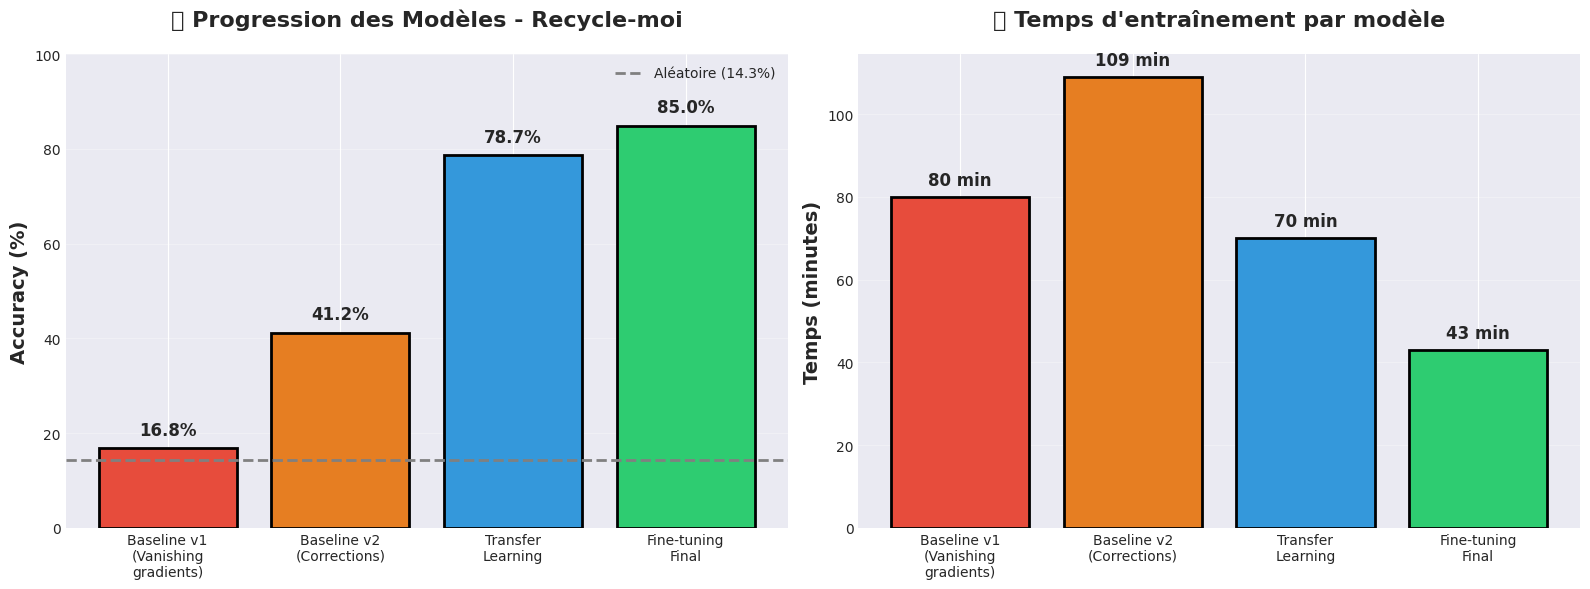

✅ Graphique sauvegardé : linkedin_progression.png


In [36]:
# CELLULE 27 : Créer le graphique de progression
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Progression des modèles
models = ['Baseline v1\n(Vanishing\ngradients)', 'Baseline v2\n(Corrections)', 'Transfer\nLearning', 'Fine-tuning\nFinal']
accuracies = [16.8, 41.2, 78.7, 84.95]
colors = ['#e74c3c', '#e67e22', '#3498db', '#2ecc71']

bars = ax1.bar(models, accuracies, color=colors, edgecolor='black', linewidth=2)
ax1.axhline(y=14.3, color='gray', linestyle='--', linewidth=2, label='Aléatoire (14.3%)')
ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('📊 Progression des Modèles - Recycle-moi', fontsize=16, fontweight='bold', pad=20)
ax1.set_ylim(0, 100)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{acc:.1f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Graphique 2 : Temps d'entraînement
times = [80, 109, 70, 43]
bars2 = ax2.bar(models, times, color=colors, edgecolor='black', linewidth=2)
ax2.set_ylabel('Temps (minutes)', fontsize=14, fontweight='bold')
ax2.set_title('⏱️ Temps d\'entraînement par modèle', fontsize=16, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3)

# Ajouter les valeurs
for bar, time in zip(bars2, times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{time} min',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('linkedin_progression.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Graphique sauvegardé : linkedin_progression.png")

/tmp/ipykernel_124691/2263728710.py:39: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_124691/2263728710.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_124691/2263728710.py:39: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_124691/2263728710.py:39: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_124691/2263728710.py:39: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_124691/2263728710.py:39: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_124691/2263728710.py:39: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel

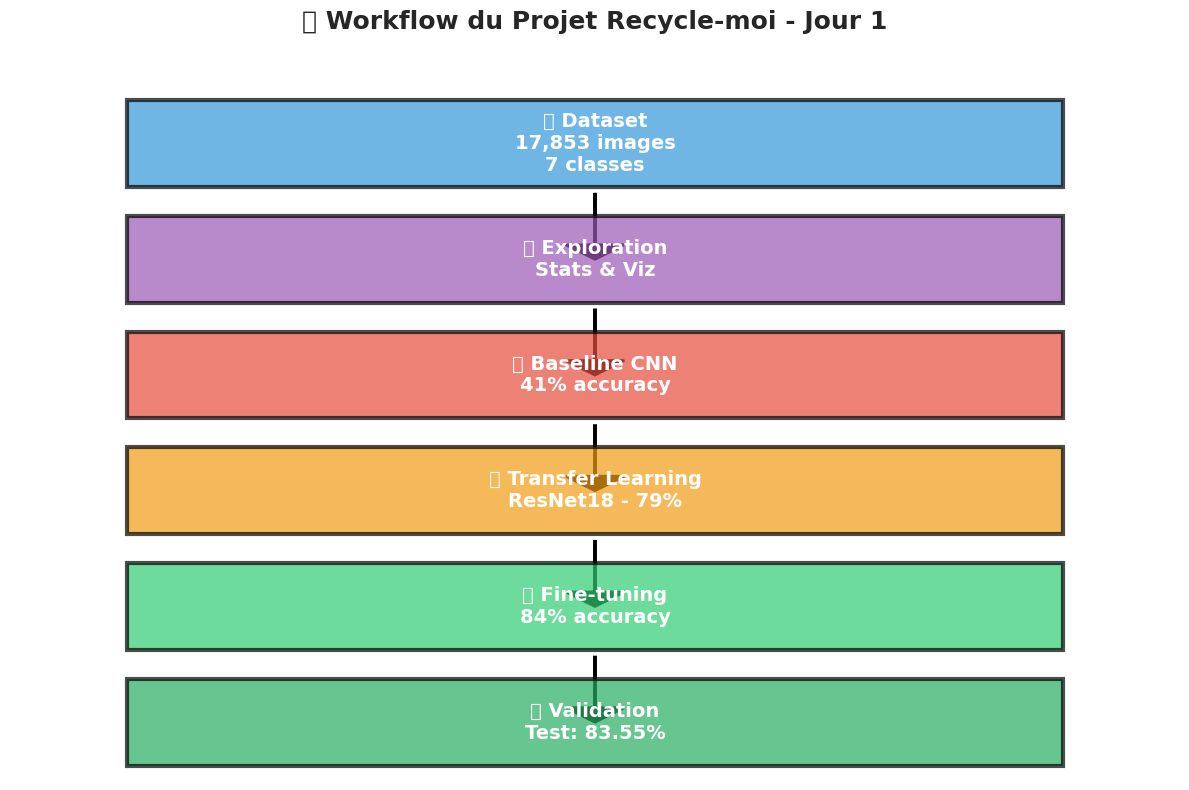

✅ Workflow sauvegardé : linkedin_workflow.png


In [37]:
# CELLULE 28 : Créer un schéma du workflow
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')

# Étapes
steps = [
    "📊 Dataset\n17,853 images\n7 classes",
    "🔍 Exploration\nStats & Viz",
    "🧪 Baseline CNN\n41% accuracy",
    "🚀 Transfer Learning\nResNet18 - 79%",
    "🔧 Fine-tuning\n84% accuracy",
    "✅ Validation\nTest: 83.55%"
]

y_positions = np.linspace(0.9, 0.1, len(steps))
colors_steps = ['#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#2ecc71', '#27ae60']

for i, (step, y, color) in enumerate(zip(steps, y_positions, colors_steps)):
    # Box
    box = plt.Rectangle((0.1, y-0.08), 0.8, 0.12, 
                        facecolor=color, edgecolor='black', 
                        linewidth=3, alpha=0.7)
    ax.add_patch(box)
    
    # Text
    ax.text(0.5, y-0.02, step, ha='center', va='center',
           fontsize=14, fontweight='bold', color='white')
    
    # Arrow
    if i < len(steps) - 1:
        ax.arrow(0.5, y-0.09, 0, -0.07, head_width=0.05, 
                head_length=0.02, fc='black', ec='black', linewidth=2)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('🎯 Workflow du Projet Recycle-moi - Jour 1', 
            fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('linkedin_workflow.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Workflow sauvegardé : linkedin_workflow.png")

/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/bavithy/miniconda3/envs/recyclemoi/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/tmp/ipykernel_124691/374345874.py:35: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_124691/374345874.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig('linkedin_confusion_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
/home/bavithy/miniconda3/envs/rec

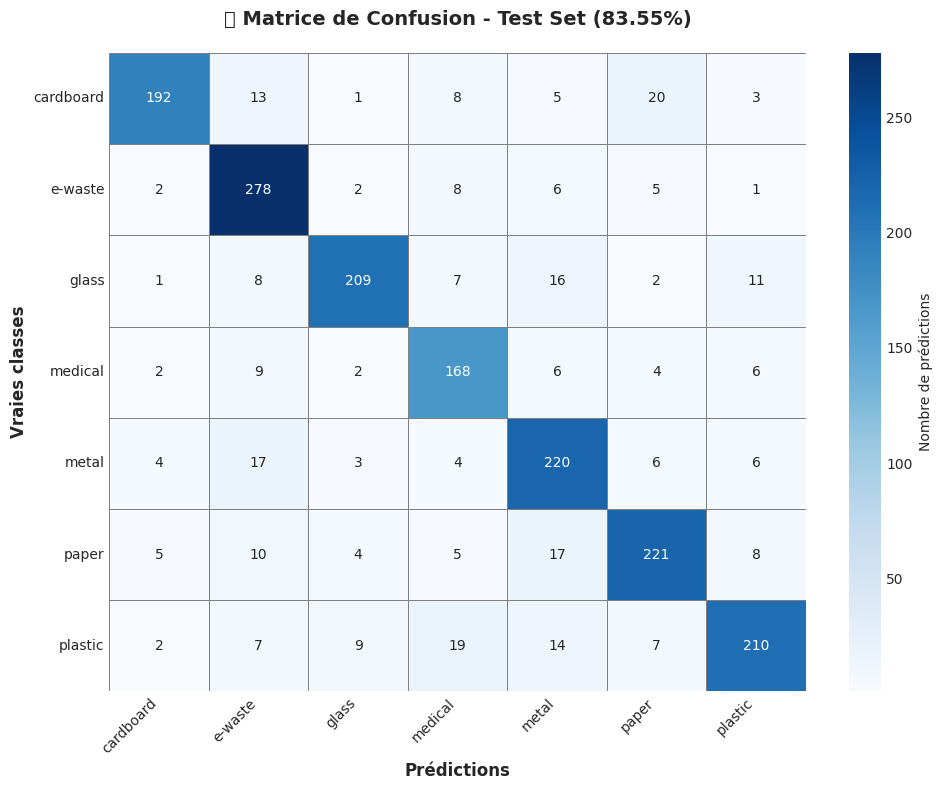

✅ Matrice de confusion sauvegardée : linkedin_confusion_matrix.png

📊 RAPPORT DE CLASSIFICATION DÉTAILLÉ
              precision    recall  f1-score   support

   cardboard       0.92      0.79      0.85       242
     e-waste       0.81      0.92      0.86       302
       glass       0.91      0.82      0.86       254
     medical       0.77      0.85      0.81       197
       metal       0.77      0.85      0.81       260
       paper       0.83      0.82      0.83       270
     plastic       0.86      0.78      0.82       268

    accuracy                           0.84      1793
   macro avg       0.84      0.83      0.83      1793
weighted avg       0.84      0.84      0.84      1793



In [40]:
# CELLULE 29 : Créer une matrice de confusion sur le test set
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Prédire sur tout le test set
model_resnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_v2:
        images = images.to(device)
        outputs = model_resnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)

# Visualisation
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar_kws={'label': 'Nombre de prédictions'},
            linewidths=0.5, linecolor='gray')

ax.set_xlabel('Prédictions', fontsize=12, fontweight='bold')
ax.set_ylabel('Vraies classes', fontsize=12, fontweight='bold')
ax.set_title('🎯 Matrice de Confusion - Test Set (83.55%)', 
            fontsize=14, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('linkedin_confusion_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Matrice de confusion sauvegardée : linkedin_confusion_matrix.png")

# Rapport détaillé
print("\n📊 RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("=" * 60)
print(classification_report(all_labels, all_preds, target_names=CLASSES))
